In [1]:
ll /global/cscratch1/sd/dstn/dr9-cosmos-subs

total 40
drwxrwxr-x 9 dstn 4096 Feb 24 16:00 80/
drwxrwxr-x 9 dstn 4096 Feb 24 16:13 81/
drwxrwxr-x 9 dstn 4096 Feb 24 16:14 82/
drwxrwxr-x 9 dstn 4096 Feb 24 16:13 83/
drwxrwxr-x 9 dstn 4096 Feb 24 16:14 84/
drwxrwxr-x 9 dstn 4096 Feb 24 16:17 85/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 86/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 87/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 88/
drwxrwxr-x 9 dstn 4096 Feb 24 16:28 89/


In [2]:
ll /global/project/projectdirs/cosmo/work/legacysurvey/dr9.1.1/

total 8
drwxrwsr-x+  9 landriau 4096 Jun  1 10:07 calib/
drwxrws---+ 12 landriau 4096 Feb 19 17:54 coadd/
drwxrws---+ 12 landriau 4096 Feb 19 17:49 logs/
drwxrwsr-x+  3 landriau 4096 Dec 11 16:13 logs-calibs/
drwxrws---+ 12 landriau 4096 Feb 19 17:49 metrics/
drwxrws---+ 12 landriau 4096 Feb 19 17:57 tractor/
drwxrws---+ 12 landriau 4096 Feb 19 17:57 tractor-i/
drwxrwsr-x+  3 landriau 4096 Dec 11 16:14 zpts/


In [3]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from photometry import Catalogue, setup_logging, utils

output_dir = os.path.join(os.environ['CSCRATCH'],'legacysim','dr9','cosmos','merged')
deep_fn = os.path.join(output_dir,'deep.fits')
subs = range(80,90)
sub_fns = [os.path.join(output_dir,'sub_{:d}.fits'.format(isub)) for isub in subs]
dr9_fn = os.path.join(output_dir,'dr9.fits')
hsc_dir = '/global/cfs/cdirs/desi/target/analysis/truth/parent'
hsc_fn = os.path.join(hsc_dir,'hsc-pdr2-dud-cosmos-reduced.fits')
truth_fn = os.path.join(os.getenv('HOME'),'photometry','truth_cosmos_deep.fits')

bands = ['g','r','z','w1','w2']
keep = ['ra','dec','brick_primary','release','brickname','objid','maskbits']
keep += ['flux_{}'.format(b) for b in bands]
keep += ['fiberflux_{}'.format(b) for b in bands[:3]]
keep += ['type','sersic','shape_r','shape_e1','shape_e2']
keep += ['galdepth_{}'.format(b) for b in bands[:3]]
keep += ['mw_transmission_{}'.format(b) for b in bands]
keep += ['ebv']

def get_catalog(fn):
    catalog = Catalogue.load_fits(fn,keep=keep)
    return catalog[catalog['brick_primary']]

def match_catalogs(deep, hsc, distance_upper_bound=1./3600.):
    index_hsc = utils.match_ra_dec([deep['ra'],deep['dec']],radec2=[hsc['ra'],hsc['dec']],nn=1,distance_upper_bound=distance_upper_bound,degree=True)
    index_deep = np.arange(deep.size)
    mask = index_hsc < hsc.size
    index_hsc = index_hsc[mask]
    index_deep = index_deep[mask]
    print('Matching {:d} sources / {:d} (cosmos) and {:d} (hsc)'.format(index_hsc.size,deep.size,hsc.size))
    print('{:.3f} (cosmos) and {:.3f} (hsc)'.format(index_hsc.size/deep.size,index_hsc.size/hsc.size))
    catalog = deep.deepcopy()
    #catalog = deep[index_deep]
    for field in ['object_id']:
        catalog['hsc_{}'.format(field)] = - catalog.ones(dtype=hsc[field].dtype)
        catalog['hsc_{}'.format(field)][index_deep] = hsc[field][index_hsc]
    for field in ['ra','dec','demp_photoz_best','mizuki_photoz_best']:
        catalog['hsc_{}'.format(field)] = np.nan*catalog.ones(dtype=hsc[field].dtype)
        catalog['hsc_{}'.format(field)][index_deep] = hsc[field][index_hsc]
    return catalog

def fill_catalog(catalog):
    for b in bands[:3]:
        catalog['brick_galdepth_{}'.format(b)] = utils.digitized_statistics(catalog['brickname'],values=catalog['galdepth_{}'.format(b)],statistic='median')
        catalog['{}fiber'.format(b)] = utils.flux_to_mag(catalog['fiberflux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
    for b in bands:
        catalog[b] = utils.flux_to_mag(catalog['flux_{}'.format(b)]/catalog['mw_transmission_{}'.format(b)])
    catalog['shape_ba'],catalog['shape_phi'] = utils.get_shape_ba_phi(catalog['shape_e1'],catalog['shape_e2'])
    return catalog

def get_maskbit(catalog, bits=[1, 5, 6, 7, 11, 12, 13]):
    mask = catalog.trues()
    for bit in bits:
        mask &= (catalog['maskbits'] & 2**bit) == 0
    return mask

def get_mask_depth(catalog, threshold=(5000.,2000.,500.)):
    #return np.all([catalog['brick_galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)
    return np.all([catalog['galdepth_{}'.format(b)] > t for (b,t) in zip(bands,threshold)],axis=0)

from preprocess import isELG_colors
def get_mask_ts(catalog, priority='all', **kwargs):
    mask_low, mask_high = isELG_colors(**{'%sflux' % b:utils.mag_to_flux(catalog[b]) for b in ['g','r','z','gfiber']},**kwargs)
    if priority == 'low': return mask_low
    if priority == 'high': return mask_high
    return (mask_low | mask_high)

In [4]:
write_input = False

if write_input:
    base_dir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9.1.1/tractor/'
    fns = glob.glob(os.path.join(base_dir,'*','tractor-*.fits'))
    catalog = 0
    setup_logging('warning')
    print('Found {:d} tractor catalogs'.format(len(fns)))
    for ifn,fn in enumerate(fns):
        #if ifn % (len(fns)//20) == 0: print('{}/{}'.format(ifn,len(fns)))
        catalog += get_catalog(fn)
    catalog.save_fits(deep_fn)
    
    base_dir = '/global/cscratch1/sd/dstn/dr9-cosmos-subs/'
    for isub,sub_fn in zip(subs,sub_fns):
        fns = glob.glob(os.path.join(base_dir,str(isub),'tractor','*','tractor-*.fits'))
        catalog = 0
        for ifn,fn in enumerate(fns): catalog += get_catalog(fn)
        catalog.save_fits(sub_fn)
    
    base_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/tractor'
    bricknames = np.unique(Catalogue.load_fits(deep_fn,keep=['brickname'])['brickname'])
    catalog = 0
    for brickname in bricknames:
        fn = os.path.join(base_dir,brickname[:3],'tractor-{}.fits'.format(brickname))
        catalog += get_catalog(fn)
    catalog.save_fits(dr9_fn)
    
write_matched = False

if write_matched:
    subs = sum([Catalogue.load_fits(sub_fn) for sub_fn in sub_fns])
    deep = Catalogue.load_fits(deep_fn)
    dr9 = Catalogue.load_fits(dr9_fn)

    catalogs = {'subs':subs,'deep':deep,'dr9':dr9}
    for catalog in catalogs.values():
        fill_catalog(catalog)
    
    hsc = Catalogue.load_fits(hsc_fn)
    catalog = match_catalogs(deep,hsc)
    catalog.save(truth_fn)

Found 811 tractor catalogs


In [2]:
# Check truth

In [ ]:
truth = Catalogue.load_fits(truth_fn)
mask = get_mask_depth(truth) & get_mask_ts(truth,gmarg=0.5,grmarg=0.5,rzmarg=0.5,priority='all')
truth = truth[mask]
mask_all = get_mask_ts(truth,gmarg=0.,grmarg=0.,rzmarg=0.,priority='all')
mask_hip = get_mask_ts(truth,gmarg=0.,grmarg=0.,rzmarg=0.,priority='high')

fig,ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(8,8))
ax.scatter(truth['r'] - truth['z'],truth['g'] - truth['r'],marker='.',color='b')
ax.scatter(truth['r'][mask_all] - truth['z'][mask_all],truth['g'][mask_all] - truth['r'][mask_all],marker='.',color='r')
ax.scatter(truth['r'][mask_hip] - truth['z'][mask_hip],truth['g'][mask_hip] - truth['r'][mask_hip],marker='.',color='g')
ax.set_xlim(-1.,2.)
ax.set_ylim(-0.5,2.)
ax.set_xlabel('$g-r$')
ax.set_ylabel('$r-z$')

fn = os.path.join(output_dir,'truth_ELG_ALL_marg05.fits')
truth.save_fits(fn)
print(truth.size)

In [9]:
hsc = Catalogue.load_fits(hsc_fn)
print(hsc.fields)

['object_id', 'ra', 'dec', 'g_psfflux_flux', 'r_psfflux_flux', 'i_psfflux_flux', 'z_psfflux_flux', 'y_psfflux_flux', 'g_psfflux_fluxsigma', 'r_psfflux_fluxsigma', 'i_psfflux_fluxsigma', 'z_psfflux_fluxsigma', 'y_psfflux_fluxsigma', 'g_cmodel_flux', 'r_cmodel_flux', 'i_cmodel_flux', 'z_cmodel_flux', 'y_cmodel_flux', 'g_cmodel_fluxsigma', 'r_cmodel_fluxsigma', 'i_cmodel_fluxsigma', 'z_cmodel_fluxsigma', 'y_cmodel_fluxsigma', 'g_cmodel_fracdev', 'r_cmodel_fracdev', 'z_cmodel_fracdev', 'g_extendedness_value', 'r_extendedness_value', 'i_extendedness_value', 'z_extendedness_value', 'g_extendedness_flag', 'r_extendedness_flag', 'i_extendedness_flag', 'z_extendedness_flag', 'g_sdsscentroid_flag', 'r_sdsscentroid_flag', 'i_sdsscentroid_flag', 'z_sdsscentroid_flag', 'y_sdsscentroid_flag', 'g_pixelflags_edge', 'r_pixelflags_edge', 'i_pixelflags_edge', 'z_pixelflags_edge', 'y_pixelflags_edge', 'g_pixelflags_interpolatedcenter', 'r_pixelflags_interpolatedcenter', 'i_pixelflags_interpolatedcenter', 

Text(0, 0.5, 'dec')

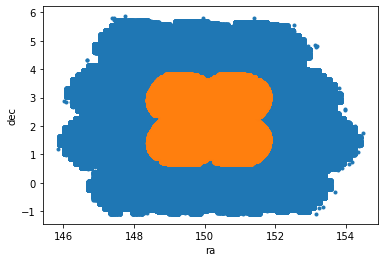

In [10]:
plt.scatter(deep['ra'],deep['dec'],marker='.',label='cosmos deep')
plt.scatter(hsc['ra'],hsc['dec'],marker='.',label='hsc')
plt.xlabel('ra')
plt.ylabel('dec')

In [13]:
prev_fn = '/project/projectdirs/desi/users/ajross/MCdata/seed.fits'
prev = Catalogue.load_fits(prev_fn)
print(prev.fields)

['brickname', 'objid', 'type', 'ra', 'dec', 'g', 'r', 'z', 'w1', 'w2', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'hsc_object_id', 'hsc_ra', 'hsc_dec', 'hsc_mizuki_photoz_best', 'rhalf']


In [1]:
from desiutil.brick import Bricks
table = Bricks().to_table()

In [ ]:
plt.scatter(table['RA1'],table['BRICKCOL'])